In [1]:
# Step 1: Install required packages
!pip install -q kaggle tensorflow-addons



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# Step 2: Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os


In [3]:
# Step 3: Upload kaggle.json
from google.colab import files
uploaded = files.upload()  # upload your kaggle.json here



Saving kaggle.json to kaggle.json


In [4]:
# Step 4: Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [5]:
# Step 5: Download and unzip dataset
!kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert
!unzip -o imdb-50k-movie-reviews-test-your-bert.zip



Dataset URL: https://www.kaggle.com/datasets/atulanandjha/imdb-50k-movie-reviews-test-your-bert
License(s): GNU Lesser General Public License 3.0
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.33GB/s]
Archive:  imdb-50k-movie-reviews-test-your-bert.zip
  inflating: test.csv                
  inflating: train.csv               


In [6]:
# Step 6: Load and preprocess the data
def load_and_preprocess_data():
    df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Rename 'sentiment' to 'label' for consistency
    df.rename(columns={'sentiment': 'label'}, inplace=True)
    test_df.rename(columns={'sentiment': 'label'}, inplace=True)

    # Correctly encode labels
    df['label'] = df['label'].map({'neg': 0, 'pos': 1})
    test_df['label'] = test_df['label'].map({'neg': 0, 'pos': 1})

    # Verify no NaN values
    if df['label'].isnull().any() or test_df['label'].isnull().any():
        raise ValueError("Label mapping failed: NaN values detected!")

    X = df['text'].values
    y = df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_test = test_df['text'].values
    y_test = test_df['label'].values

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data()


In [7]:

# Step 7: Tokenization and padding
def tokenize_text(X_train, X_val, X_test=None, vocab_size=10000, max_len=200):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

    if X_test is not None:
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
    else:
        X_test_pad = None

    return X_train_pad, X_val_pad, X_test_pad, tokenizer

X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_text(X_train, X_val, X_test)


In [8]:
# Step 8: Build model
def build_model(vocab_size=10000, embedding_dim=128, max_len=200):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len, mask_zero=True),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), dropout=0.3, recurrent_dropout=0.3)),
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
# Step 9: Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])



In [10]:
# Step 10: Define callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]



In [11]:
# Step 11: Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_val_pad, y_val),
                    callbacks=callbacks,
                    verbose=1)



Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5310 - auc: 0.5442 - loss: 6.3675 - precision: 0.5327 - recall: 0.5110

157/157 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.5313 - auc: 0.5448 - loss: 6.3531 - precision: 0.5331 - recall: 0.5116 - val_accuracy: 0.7942 - val_auc: 0.8837 - val_loss: 1.2036 - val_precision: 0.7461 - val_recall: 0.8905 - learning_rate: 5.0000e-04
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.7883 - auc: 0.8417 - loss: 0.9276 - precision: 0.7924 - recall: 0.7861 - val_accuracy: 0.8372 - val_auc: 0.9227 - val_loss: 0.5000 - val_precision: 0.8740 - val_recall: 0.7871 - learning_rate: 5.0000e-04
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8506 - auc: 0.9038 - loss: 0.4969 - precision: 0.8485 - recall: 0.8531

157/157 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.8505 - auc: 0.9037 - loss: 0.4970 - precision: 0.8484 - recall: 0.8530 - val_accuracy: 0.7936 - val_auc: 0.8639 - val_loss: 0.5728 - val_precision: 0.9079 - val_recall: 0.6524 - learning_rate: 5.0000e-04
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.8351 - auc: 0.8893 - loss: 0.5106 - precision: 0.8244 - recall: 0.8552 - val_accuracy: 0.8506 - val_auc: 0.9262 - val_loss: 0.4282 - val_precision: 0.8498 - val_recall: 0.8508 - learning_rate: 5.0000e-04
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.8886 - auc: 0.9430 - loss: 0.3765 - precision: 0.8798 - recall: 0.8994 - val_accuracy: 0.8510 - val_auc: 0.9266 - val_loss: 0.4124 - val_precision: 0.8588 - val_recall: 0.8392 - learning_rate: 5.0000e-04
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.9111 - auc: 0.9583 - loss: 0.3140 - precision: 0.9119 - recall: 0.9117 - val_accuracy: 0.8552 - val_auc: 0.9299 - val_loss: 0.3975 

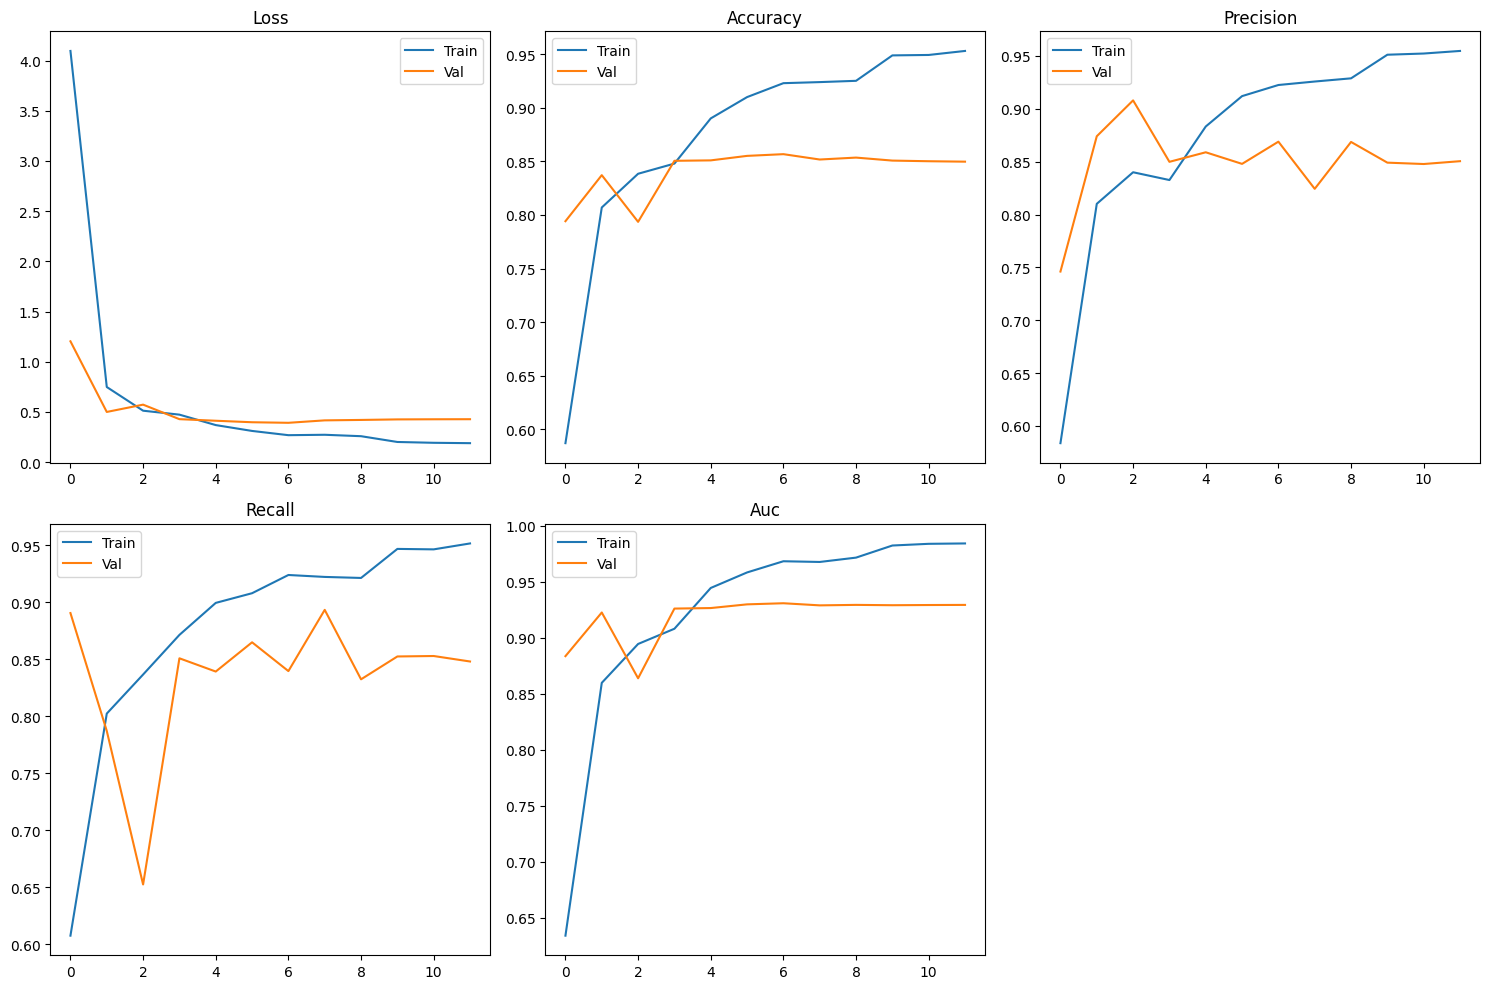

In [12]:
# Step 12: Plot metrics
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [13]:
# Step 13: Evaluate on test set
if X_test_pad is not None and y_test is not None:
    results = model.evaluate(X_test_pad, y_test, verbose=0)
    print("\nTest Metrics:")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Precision: {results[2]:.4f}")
    print(f"Recall: {results[3]:.4f}")
    print(f"AUC: {results[4]:.4f}")
    f1_score = 2 * (results[2] * results[3]) / (results[2] + results[3])
    print(f"F1 Score: {f1_score:.4f}")
else:
    print("No test labels available")




Test Metrics:
Accuracy: 0.8433
Precision: 0.8622
Recall: 0.8172
AUC: 0.9225
F1 Score: 0.8391


In [14]:
# Step 14: Save model and tokenizer
model.save('imdb_sentiment_bilstm.h5')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [15]:
# Step 15: Predict sentiment
def predict_sentiment(text, model, tokenizer, max_len=200, return_proba=False):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    proba = model.predict(padded, verbose=0)[0][0]
    sentiment = 'Positive' if proba > 0.5 else 'Negative'
    confidence = proba if sentiment == 'Positive' else 1 - proba
    return (sentiment, confidence, proba) if return_proba else (sentiment, confidence)


In [16]:
# Step 16: Test predictions
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "I hated this movie from start to finish. The worst acting I've ever seen.",
    "The film was okay, nothing special but not terrible either.",
    "The cinematography was beautiful but the story was lacking depth."
]

print("\nSample Predictions:")
for review in sample_reviews:
    sentiment, confidence, proba = predict_sentiment(review, model, tokenizer, return_proba=True)
    print(f"\nReview: {review[:80]}...")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Raw Probability: {proba:.4f}")


Sample Predictions:

Review: This movie was absolutely fantastic! The acting was superb and the plot was enga...
Prediction: Positive
Confidence: 74.69%
Raw Probability: 0.7469

Review: I hated this movie from start to finish. The worst acting I've ever seen....
Prediction: Negative
Confidence: 94.49%
Raw Probability: 0.0551

Review: The film was okay, nothing special but not terrible either....
Prediction: Negative
Confidence: 84.42%
Raw Probability: 0.1558

Review: The cinematography was beautiful but the story was lacking depth....
Prediction: Negative
Confidence: 57.58%
Raw Probability: 0.4242


In [17]:
from google.colab import files

# Download model
files.download('imdb_sentiment_bilstm.h5')

# Download tokenizer
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>